# Setup

### Import libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import datetime
from src import (get_data as gd, 
                 prepare as prep, 
                 aggregate_data as aggregate,
                 push_data,
                 sedi_rate,
                 age_sr_plot)
###
orig_dir = os.getcwd()

# Main Data

### Retrieve data 

In [14]:
dates = gd.AgeFromFileOneCore()

FileChooser(path='E:\LANDO\input_files', filename='', title='', show_hidden=False, select_desc='Select', chang…

In [15]:
dates.get_dates()

### Add calibration curve to data

In [16]:
dates.select_calibration_curve(default_curve = 'IntCal20', user_selection = False)

In [17]:
dates.add_calibration_curve()

### Put data in variables

In [18]:
AllAges = dates.all_ages
CoreIDs = dates.all_coreid_list
CoreLengths = dates.all_core_lengths
SR_mode = 'naive'

# Reservoir correction

#### Prep

In [19]:
os.chdir(orig_dir)
RC = prep.PrepForReservoirCorrection(all_ages = AllAges)
RC.prep_it()
RC_Frame = RC.RC_Frame
RC_CoreIDs = RC.RC_CoreIDs
RC_CoreLengths = CoreLengths[CoreLengths.coreid.isin(RC_CoreIDs)]

#### R run

In [20]:
%get RC_Frame --from SoS 
%get RC_CoreIDs --from SoS
%get RC_CoreLengths --from SoS

In [21]:
K <- c(10,10)
source('src/Run_DefineReservoir.R', local = TRUE)

In [22]:
%put reservoir_core_results

#### Aggregate results

In [23]:
aggRC = aggregate.AggDataReservoir(results = reservoir_core_results,
                                   surface_dates = RC.desired_surface_dates,
                                   verbose = 0)
aggRC.results_agg()

In [24]:
AllAges = aggRC.add_reservoir(all_ages = AllAges)

Would you like to add the reservoir values to all samples ('all'), to only bulk samples ('bulk'), or disregard the values ('without')? all


# Calibration
#### Prep

In [25]:
calib = prep.PrepForCalibration(all_ages = AllAges)
calib.prep_it()
calib_Frame = calib.calib_Frame

#### R run

In [26]:
%get calib_Frame --from SoS

In [27]:
source('src/Run_calibration.R', local = TRUE)

In [28]:
%put calib_dates

# Age Modeling
### UNDATABLE
#### Prep

In [29]:
Undatable = prep.PrepForUndatable(all_ages = AllAges, 
                                  all_coreid_list = CoreIDs)
Undatable.prep_it()
CoreIDs_df = Undatable.coreid_df

New files for Undatable created!


#### Octave run

In [30]:
%get CoreIDs_df --from SoS
xfactor = 0.1;
bootpc = 30;
run_Undatable(CoreIDs_df, xfactor, bootpc);

#### Aggregate results

In [31]:
aggU = aggregate.AggDataUndatable(Undatable, orig_dir, dttp = aggRC.dttp)
aggU.results_agg()

#### Calculate sedimentation rate

In [32]:
SRUn = sedi_rate.CalculateSediRate(aggU, model = 'Undatable', coreid = CoreIDs, mode = SR_mode)
SRUn.calculating_SR()

#### Push results to database

In [33]:
push = push_data.PushIt(agg = aggU,
                        engine = dates.engine,
                        model = 'Undatable')
push.push_to_db()

Nothing to upload!


In [34]:
os.chdir(orig_dir)
push.delete_files(location_UndatableFolder = Undatable.location_UndatableFolder,
                  coreids = Undatable.coreid_df)

All files have been deleted!


### Bchron

#### Prep

In [35]:
os.chdir(orig_dir)
Bchron = prep.PrepForBchron(all_ages = AllAges)
Bchron.prep_it()
Bchron_Frame = Bchron.Bchron_Frame

#### R run

In [36]:
%get Bchron_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [37]:
source('src/Run_Bchron.R')

In [38]:
%put Bchron_core_results

#### Aggregate results

In [39]:
aggBc = aggregate.AggDataBchron(Bchron_core_results, dttp = aggRC.dttp)
aggBc.results_agg()

#### Calculating sedimentation rate

In [40]:
SRBc = sedi_rate.CalculateSediRate(aggBc, model = 'Bchron', coreid = CoreIDs, mode = SR_mode)
SRBc.calculating_SR()

#### Push results to database

In [41]:
push = push_data.PushIt(agg = aggBc,
                        engine = dates.engine,
                        model = 'Bchron')
push.push_to_db()

Nothing to upload!


### hamstr

#### Prep

In [42]:
hamstr = prep.PrepForHamstr(all_ages = AllAges)
hamstr.prep_it()
hamstr_Frame = hamstr.hamstr_Frame

#### R Run

In [43]:
%get hamstr_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [44]:
K <- c(10,10)
source('src/Run_hamstr.R', local = TRUE)

In [45]:
%put hamstr_core_results

#### Aggregate

In [46]:
aggh = aggregate.AggDataHamstr(hamstr_core_results, dttp = aggRC.dttp)
aggh.results_agg()

#### Calculating sedimentation rate

In [47]:
SRh = sedi_rate.CalculateSediRate(aggh, model = 'hamstr', coreid = CoreIDs, mode = SR_mode)
SRh.calculating_SR()

#### Push results to database

In [48]:
push = push_data.PushIt(agg = aggh,
                        engine = dates.engine,
                        model = 'hamstr')
push.push_to_db()

Nothing to upload!


### Bacon

#### Prep

In [49]:
Bacon = prep.PrepForBacon(all_ages = AllAges)
Bacon.prep_it()
Bacon_Frame = Bacon.Bacon_Frame

#### R Run

In [50]:
%get Bacon_Frame --from SoS 
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [51]:
acc.shape <- 1.5
acc.mean <- 20
mem.strength <- 10
mem.mean <- 0.5
ssize <- 8000
source('src/Run_Bacon.R', local = TRUE)

In [52]:
%put Bacon_core_results

#### Aggregate

In [53]:
aggBa = aggregate.AggDataBacon(Bacon_core_results, dttp = aggRC.dttp)
aggBa.results_agg()

#### Calculating sedimentation rate

In [54]:
SRBa = sedi_rate.CalculateSediRate(aggBa, model = 'Bacon', coreid = CoreIDs, mode = SR_mode)
SRBa.calculating_SR()

#### Push results to database

In [55]:
push = push_data.PushIt(agg = aggBa,
                        engine = dates.engine,
                        model = 'Bacon')
push.push_to_db()

Nothing to upload!


### Clam

#### Prep

In [56]:
clam = prep.PrepForClam(all_ages = AllAges)
clam.prep_it()
clam_Frame = clam.clam_Frame

#### R Run

In [57]:
%get clam_Frame --from SoS
%get CoreIDs --from SoS
%get CoreLengths --from SoS

In [58]:
types_curve <- 1:5
smoothness_curve <- 0.1*(1:10)
poly_degree_curve <- 1:4
best_fit <- TRUE

In [59]:
source('src/Run_clam.R', local = TRUE)

 Done with core EN18218 - Number 1 out of 1



In [60]:
%put clam_core_results

#### Aggregate

In [61]:
aggcl = aggregate.AggDataClam(clam_core_results, dttp = aggRC.dttp)
aggcl.results_agg()

#### Calculating sedimentation rate

In [62]:
SRcl = sedi_rate.CalculateSediRate(aggcl, model = 'clam', coreid = CoreIDs, mode = SR_mode)
SRcl.calculating_SR()

#### Push results to database

In [63]:
push = push_data.PushIt(agg = aggcl,
                        engine = dates.engine,
                        model = 'clam')
push.push_to_db()

Nothing to upload!


# Plotting

In [64]:
plot_data = {'Undatable' : [aggU.age_model_result_Undatable, SRUn.SR_model_result_Undatable],
             'Bchron': [aggBc.age_model_result_Bchron, SRBc.SR_model_result_Bchron],
             'hamstr': [aggh.age_model_result_hamstr, SRh.SR_model_result_hamstr],
             'Bacon': [aggBa.age_model_result_Bacon, SRBa.SR_model_result_Bacon],
             'clam': [aggcl.age_model_result_clam, SRcl.SR_model_result_clam],
             'calib_dates': calib_dates}

In [65]:
ASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

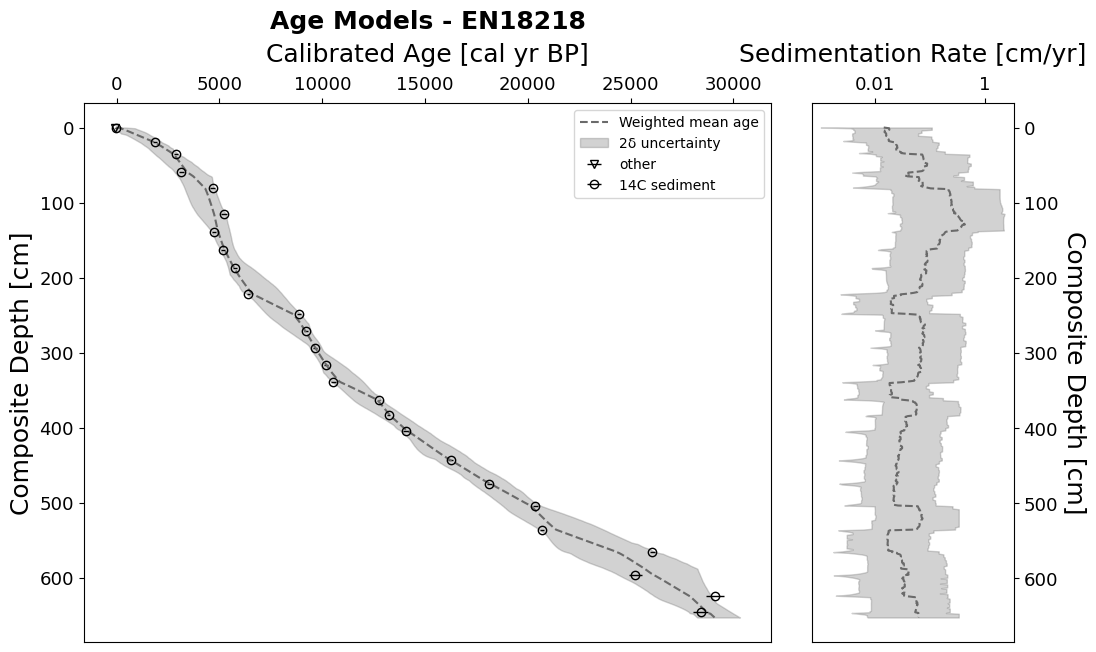

In [68]:
ASRplot.plot_graph(orig_dir = orig_dir, sigma_range = 'both',
                   bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                   only_combined = True, save = True, for_color_blind = False, as_jpg = False)

# Optimization

In [ ]:
proxy = gd.ProxyFromFile()

In [ ]:
proxy_ts = proxy.get_proxy()
###
dict_model_name = ASRplot.dict_model_name
dict_SR_median_age = ASRplot.dict_SR_median_age

In [ ]:
%get dict_SR_median_age --from SoS
%get dict_model_name --from SoS
%get proxy_ts --from SoS

In [ ]:
curr_nreps     <- 1000
curr_minseg    <- 50
curr_cptmethod <- "mean+variance"

In [ ]:
source('src/Run_Optimization.R', local = TRUE)

In [ ]:
%put result_list 
%put fitting_values

In [ ]:
optimizedASRplot = age_sr_plot.PlotAgeSR(plot_data, coreid = CoreIDs, dttp = aggRC.dttp)

In [ ]:
optimizedASRplot.plot_optimized_graph(optimization_values = result_list, fitting_values = fitting_values, 
                                      proxy = proxy.name, proxy_data = proxy_ts, orig_dir = orig_dir, 
                                      sigma_range = 'both', inclusion_threshold = 0.03, show_fitting_models = True,
                                      bin_size = 1000, xlim_max = 21000, number_col = 8, reduce_plot_axis = True,
                                      only_combined = True, save = True, for_color_blind = False, as_jpg = False)